In [1]:
from aif360.datasets import CompasDataset
from aif360.metrics import ClassificationMetric

from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
cd = CompasDataset()
print(cd.features.shape)

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/aif360/datasets/standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))


(6167, 401)


In [3]:
train, val = cd.split([0.75], shuffle=True)

model = LogisticRegression(solver='liblinear', random_state=0).fit(
    train.features, train.labels.ravel()
)

In [4]:
def generate_fairness_test_report(dataset, model, thresholds, 
                                  privileged_groups, unprivileged_groups):
    y_pred_prob = model.predict_proba(dataset.features)
    positive_index = np.where(model.classes_ == dataset.favorable_label)[0][0]
    print(y_pred_prob.shape)
    print(positive_index)
    
    results = defaultdict(list)
    for threshold in thresholds:
        y_pred = (y_pred_prob[:, positive_index] > threshold).astype(np.float64)
        
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_pred
        
        metric = ClassificationMetric(
            dataset, dataset_pred,
            privileged_groups=privileged_groups,
            unprivileged_groups=unprivileged_groups
        )
        results['acc'].append(metric.accuracy())
        results['avg_odds_diff'].append(metric.average_odds_difference())
        results['disparate_imp'].append(metric.disparate_impact())
        results['stat_parity_diff'].append(metric.statistical_parity_difference())
        results['eq_opp_diff'].append(metric.equal_opportunity_difference())
        results['theil_index'].append(metric.theil_index())
    
    return results


def plot_test_results(x, x_label, y_left, y_left_label, y_right, y_right_label):
    f, ax1 = plt.subplots(figsize=(13, 10))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_label, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_label, fontsize=16, color='b', fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    
    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_label, fontsize=16, color='r', fontweight='bold')
    
    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    
    plt.show()

In [6]:
thresholds = np.linspace(0.01, 1, 100)
results = generate_fairness_test_report(
    val, model, thresholds,
    privileged_groups=[{'race': 1}],
    unprivileged_groups=[{'race': 0}]
)
best_ind = np.argmax(results['acc'])
print(best_ind)

(1542, 2)
0
97


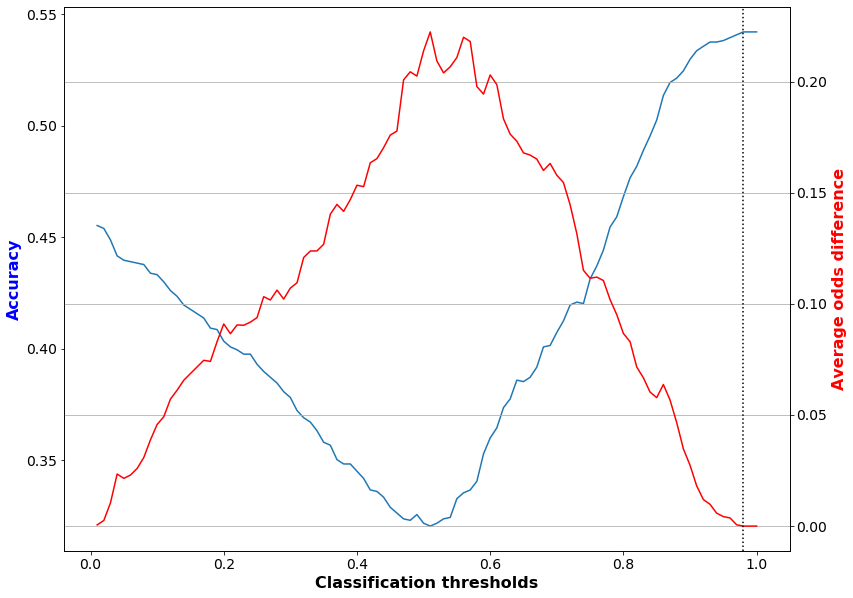

In [8]:
plot_test_results(
    thresholds, 'Classification thresholds',
    results['acc'], 'Accuracy',
    results['avg_odds_diff'], 'Average odds difference'
)

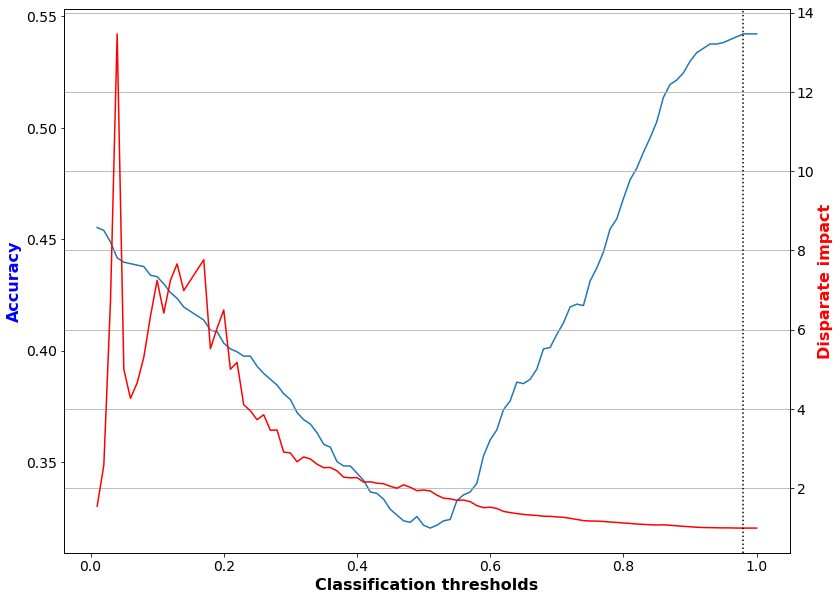

In [11]:
plot_test_results(
    thresholds, 'Classification thresholds',
    results['acc'], 'Accuracy',
    results['disparate_imp'], 'Disparate impact'
)

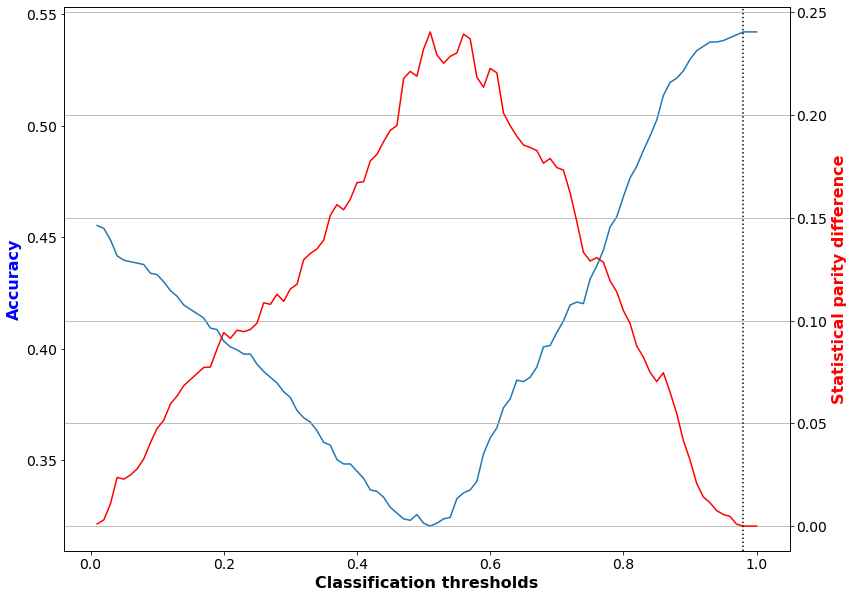

In [10]:
plot_test_results(
    thresholds, 'Classification thresholds',
    results['acc'], 'Accuracy',
    results['stat_parity_diff'], 'Statistical parity difference'
)

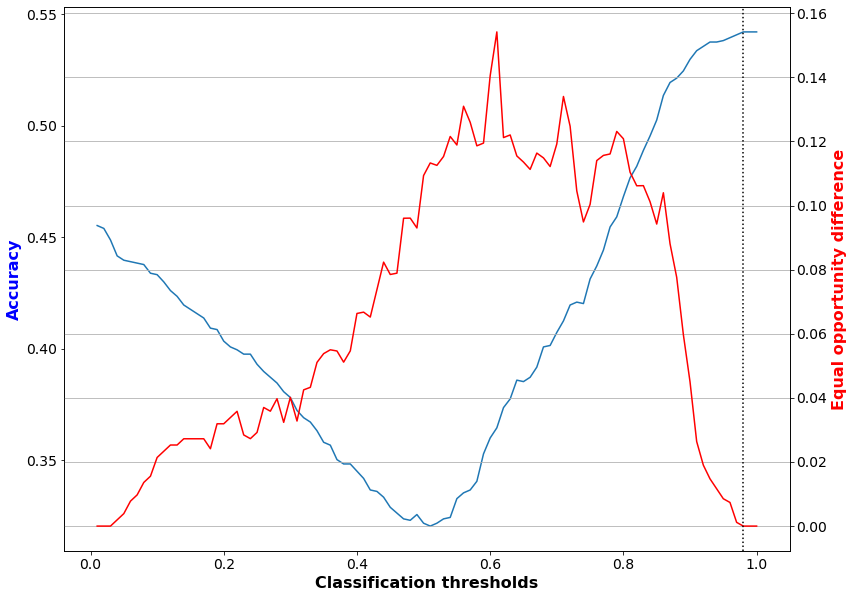

In [13]:
plot_test_results(
    thresholds, 'Classification thresholds',
    results['acc'], 'Accuracy',
    results['eq_opp_diff'], 'Equal opportunity difference'
)

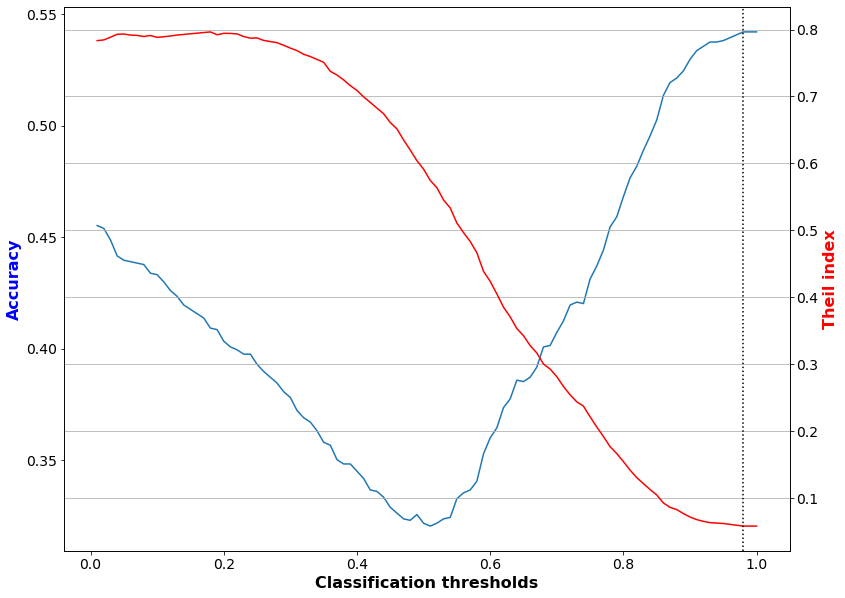

In [15]:
plot_test_results(
    thresholds, 'Classification thresholds',
    results['acc'], 'Accuracy',
    results['theil_index'], 'Theil index'
)
